In [1]:
from google.colab import drive,files
files.upload()

Saving QuoraQuestionPairDataset.zip to QuoraQuestionPairDataset.zip


In [2]:
!unzip QuoraQuestionPairDataset.zip

Archive:  QuoraQuestionPairDataset.zip
  inflating: questions.csv           


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import os
import sys
import re
import datetime as dt
import string

In [4]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
%matplotlib inline

from tqdm.notebook import tqdm

In [5]:
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
#os.listdir()

['.config', 'QuoraQuestionPairDataset.zip', 'questions.csv', 'sample_data']

In [6]:
df = pd.read_csv("questions.csv")

In [7]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Text(0.5, 1.0, 'Count of missing values per column')

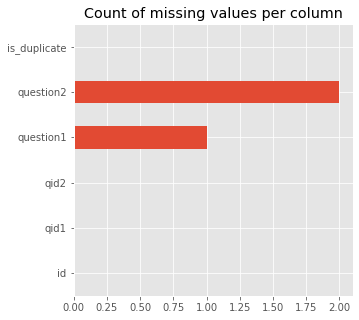

In [8]:
plt.figure(figsize=(5, 5))
df.isna().sum(axis=0).plot.barh()
plt.title('Count of missing values per column')

In [9]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows) # output rows with null entry

df = df.fillna('') # fillna

nan_rows = df[df.isnull().any(1)]
print(nan_rows) # output rows with null entry

            id  ...  is_duplicate
105796  105796  ...             0
201871  201871  ...             0
363416  363416  ...             0

[3 rows x 6 columns]
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404351 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404351 non-null  int64 
 1   qid1          404351 non-null  int64 
 2   qid2          404351 non-null  int64 
 3   question1     404351 non-null  object
 4   question2     404351 non-null  object
 5   is_duplicate  404351 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [11]:
duplicates =  df.duplicated() #['qid1','qid2','is_duplicate']
duplicates.sum(axis=0)
df[duplicates]

,id,qid1,qid2,question1,question2,is_duplicate


In [12]:
df = df.drop_duplicates()

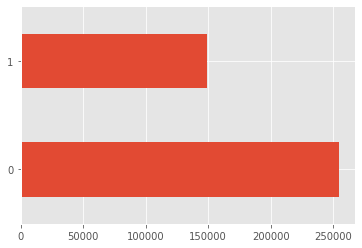

In [13]:
df['is_duplicate'].value_counts().plot.barh()

In [14]:
print("{:.2f}% of the question pairs are not duplicates".format(100*df['is_duplicate'].value_counts().to_frame().iloc[0]['is_duplicate']/df.shape[0]))
print("{:.2f}% of the question pairs are duplicates".format(100*df['is_duplicate'].value_counts().to_frame().iloc[1]['is_duplicate']/df.shape[0]))

63.08% of the question pairs are not duplicates
36.92% of the question pairs are duplicates


In [16]:
all_questions = [*df['question1'].to_list(), *df['question2'].to_list()]
unique_questions = list(set(all_questions))
print("Number of unique questions:", len(unique_questions))

Number of unique questions: 537388


In [17]:
print("{} qids intersect in pair formation".format(len(list(set(df.qid2) & set(df.qid1)))))

7474 qids intersect in pair formation


In [ ]:

#intersection = list(set(df.qid2) & set(df.qid1))
#qid_list = [*df['qid1'].to_list(),*df['qid2'].to_list()]

#print("{}", )
#qid2_list = [*df['qid2'].to_list()]
#diff_2_from_1 = [qid for qid in qid2_list if qid not in intersection]
#unique_qids = [*df['qid1'].to_list(), *diff_2_from_1]

In [18]:
freq = nltk.FreqDist(all_questions)

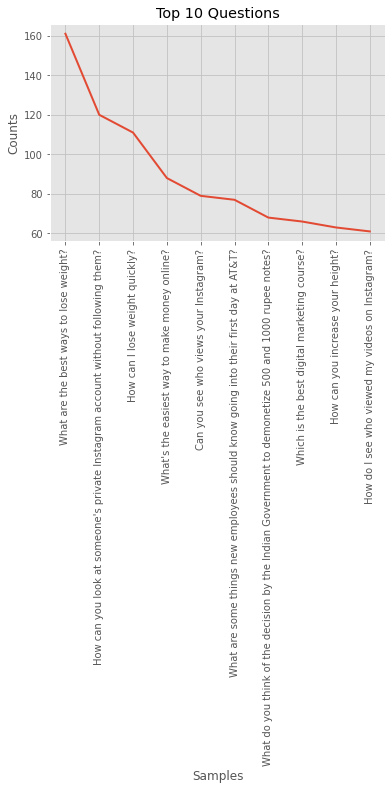

Most asked question being: What are the best ways to lose weight?


In [19]:
freq.plot(10, cumulative=False, title="Top 10 Questions")
print("Most asked question being:",freq.max())

In [21]:
more_than_once = [q for q,count in freq.items() if count >= 2]

In [22]:
print("{0:.2f}% of questions occur more than once".format(100*len(more_than_once)/len(unique_questions)))

20.82% of questions occur more than once


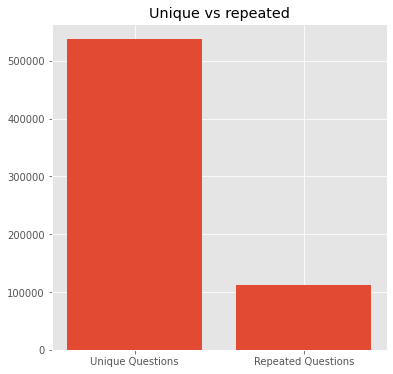

In [23]:
x = ["Unique Questions","Repeated Questions"]
xpos = [i for i, _ in enumerate(x)]
plt.figure(figsize=(6,6))
plt.title("Unique vs repeated")
plt.bar(xpos, [len(unique_questions),len(more_than_once)])
plt.xticks(xpos, x)
plt.show()

#Preprocessing Text

In [24]:

class ProcessText:
  def __init__(self):
    if not all(pkg in globals() for pkg in ("string","re","nltk","BeautifulSoup","SnowballStemmer","tqdm")):
      raise Exception("[Error] Dependencies not satisfied.")
    
    self.stop_words = ['the','a','an','and','but','if','or','because','as','what','which','this','that','these','those','then',
              'just','so','than','such','both','through','about','for','is','of','while','during','to','What','Which',
              'Is','If','While','This']
    self.doc_list = []

  def process_corpus(self, corpus=[], remove_stop_words=True, stem_words=False):
    self.doc_list = []
    if len(corpus) != 0:
      for doc in tqdm(corpus):
          self.doc_list.append(self.process_text(remove_stop_words, stem_words,doc))
      return self.doc_list

  def process_text(self, remove_stop_words, stem_words, text=''):
    if len(text) != 0:
      text = self.__remove_html(text)
      text = self.__clean_text(text)
      text = self.__clean_punctuation(text)
      if remove_stop_words:
        text = self.__remove_stopwords(text)
      if stem_words:
        text = self.__stem(text)
      return text

  def __remove_html(self,txt):
    bt_soup = BeautifulSoup(txt)
    txt = bt_soup.get_text()
    del bt_soup
    return txt
  
  def __clean_text(self,text):
    # Clean the text
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e-mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"quikly", "quickly", text)
    text = re.sub(r" usa ", " America ", text)
    text = re.sub(r" USA ", " America ", text)
    text = re.sub(r" u s ", " America ", text)
    text = re.sub(r" uk ", " England ", text)
    text = re.sub(r" UK ", " England ", text)
    text = re.sub(r"india", "India", text)
    text = re.sub(r"switzerland", "Switzerland", text)
    text = re.sub(r"china", "China", text)
    text = re.sub(r"chinese", "Chinese", text) 
    text = re.sub(r"imrovement", "improvement", text)
    text = re.sub(r"intially", "initially", text)
    text = re.sub(r"quora", "Quora", text)
    text = re.sub(r" dms ", "direct messages ", text)  
    text = re.sub(r"demonitization", "demonetization", text) 
    text = re.sub(r"actived", "active", text)
    text = re.sub(r"kms", " kilometers ", text)
    text = re.sub(r"KMs", " kilometers ", text)
    text = re.sub(r" cs ", " computer science ", text) 
    text = re.sub(r" upvotes ", " up votes ", text)
    text = re.sub(r" iPhone ", " phone ", text)
    text = re.sub(r"\0rs ", " rs ", text) 
    text = re.sub(r"calender", "calendar", text)
    text = re.sub(r"ios", "operating system", text)
    text = re.sub(r"gps", "GPS", text)
    text = re.sub(r"gst", "GST", text)
    text = re.sub(r"programing", "programming", text)
    text = re.sub(r"bestfriend", "best friend", text)
    text = re.sub(r"dna", "DNA", text)
    text = re.sub(r"III", "3", text) 
    text = re.sub(r"the US", "America", text)
    text = re.sub(r"Astrology", "astrology", text)
    text = re.sub(r"Method", "method", text)
    text = re.sub(r"Find", "find", text) 
    text = re.sub(r"banglore", "Banglore", text)
    text = re.sub(r" J K ", " JK ", text)
    return text

  def __clean_punctuation(self,text):
    #text = ''.join([c for c in text if c not in punctuation])
    # alternatively
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

  def __remove_stopwords(self,text):
    text = text.split()
    text = [w for w in text if not w in self.stop_words]
    text = " ".join(text)
    return text


  def __stem(self,text):
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return text

In [25]:
pt = ProcessText()

In [26]:
df['question1'] = pt.process_corpus(df['question1'])
df['question2'] = pt.process_corpus(df['question2'])

/usr/local/lib/python3.7/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


            id  ...  is_duplicate
105796  105796  ...             0
201871  201871  ...             0
363416  363416  ...             0

[3 rows x 6 columns]
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


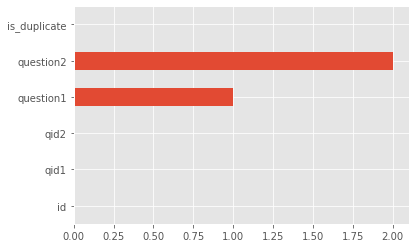

In [27]:
df.isna().sum().plot.barh()

nan_rows = df[df.isna().any(1)]
print(nan_rows)

df = df.fillna('')

nan_rows = df[df.isna().any(1)]
print(nan_rows)

#Embedding

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools
from sklearn.model_selection import train_test_split as tts
from prettytable import PrettyTable 

In [29]:
from keras.preprocessing.sequence import pad_sequences

In [37]:
#Count BOW
count_vectorizer = CountVectorizer(max_features=10000).fit(
    itertools.chain(df['question1'], df['question2']))

In [ ]:
count_vectorizer.vocabulary_ # {token: indice_in_count_table}

In [39]:
max_index = len(count_vectorizer.vocabulary_) #10000

In [40]:
words_tokenizer = re.compile(count_vectorizer.token_pattern)

In [41]:
#words_tokenizer.findall('a quick brown fox, over a lazy dog'.lower())

In [42]:
def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [count_vectorizer.vocabulary_[w] if w in count_vectorizer.vocabulary_ else max_index
         for w in words_tokenizer.findall(s.lower())]) # re.findall() matches
    return pad_sequences(seqs, maxlen=max_len)

In [43]:
x1_train, x1_test,\
x2_train, x2_test,\
y_train, y_test = tts(create_padded_seqs(df['question1']),create_padded_seqs(df['question2']),\
                      df['is_duplicate'], test_size = 0.2, random_state = 99,\
                      stratify=df['is_duplicate'].values)

In [47]:
import keras.layers as lyr
from keras.models import Model

In [50]:
x1_train.shape[1:]

(10,)

In [54]:
input1_tensor = lyr.Input(x1_train.shape[1:])
input2_tensor = lyr.Input(x2_train.shape[1:])

max_ = x1_train.max() + 1 # input dim (...and the largest integer (i.e. word index) in the input should be no larger than vocabulary size).)
words_embedding_layer = lyr.Embedding(max_, 100, input_length= 10)
lstm_seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: lstm_seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)
output_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], output_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 100)      1000100     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          365568      embedding_1[0][0]          

In [96]:
model.fit([x1_train, x2_train], y_train, 
          validation_data=([x1_test, x2_test], y_test), 
          batch_size=128, epochs=4, verbose=1)

Epoch 1/4
2528/2528 [==============================] - 370s 146ms/step - loss: 0.4549 - val_loss: 0.4599
Epoch 2/4
2528/2528 [==============================] - 369s 146ms/step - loss: 0.4183 - val_loss: 0.4458
Epoch 3/4
2528/2528 [==============================] - 370s 146ms/step - loss: 0.3827 - val_loss: 0.4397
Epoch 4/4
2528/2528 [==============================] - 369s 146ms/step - loss: 0.3483 - val_loss: 0.4307


In [112]:
print( y_test.to_numpy()[965])

1


In [79]:
#x1_test[991][0:].shape

(10,)

In [101]:
np.expand_dims(x1_test[333], axis=0).shape

(1, 10)

In [114]:
xq = [ np.expand_dims(x1_test[965], axis=0) , np.expand_dims(x2_test[965], axis=0) ]
y_pred = model.predict(xq)
y_pred

array([[0.8248368]], dtype=float32)

Extract Feature Representation


```
Input ===> Embedding ===> LSTM ===> Multipy(Output)
```
-------


In [103]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [104]:
f_train = features_model.predict([x1_train, x2_train], batch_size=128)
f_test = features_model.predict([x1_test, x2_test], batch_size=128)

In [106]:
xq = [ np.expand_dims(x1_test[1234], axis=0) , np.expand_dims(x2_test[1234], axis=0) ]

#print(xq)
y_pred = features_model.predict(xq)
y_pred

array([[ 8.64929985e-03, -1.88293591e-01,  9.93622234e-05,
         2.93876207e-03,  3.81174311e-03,  4.68317474e-08,
         9.47554529e-01,  2.12233397e-03,  2.48057325e-03,
         1.66260835e-03, -6.06299108e-11,  6.63058102e-01,
         3.11673563e-02,  1.02588110e-01,  2.30318662e-02,
         1.39892027e-02,  2.52404142e-09,  9.26116049e-01,
         3.37898877e-04,  1.31710677e-03,  5.32945991e-03,
         4.96385503e-04,  5.18515659e-03,  4.55176132e-03,
         6.94016993e-01,  7.90087729e-09,  7.32846484e-02,
         4.13861890e-05,  2.95226481e-02,  7.39455462e-01,
         9.57666562e-05,  3.59146995e-03,  9.38669920e-01,
        -1.01928666e-01,  7.44472397e-03,  9.53388095e-01,
         9.74237561e-01,  9.17754164e-07, -6.20730789e-05,
         5.80817925e-07,  1.87357632e-03,  5.30645812e-05,
         3.00756983e-05,  1.28952703e-02,  3.31926644e-02,
         2.55602981e-06,  1.89757688e-04,  4.19313796e-02,
         4.27249730e-01,  3.71672702e-03,  9.76034440e-0